In [1]:
%matplotlib inline
from collections import OrderedDict
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotting as mplt
import seaborn as sns
import sys

pkg_dir = '/home/mrossol/NaTGenPD'
#pkg_dir = '..'
sys.path.append(pkg_dir)
import NaTGenPD as npd
import NaTGenPD.cluster as cluster
from NaTGenPD.analysis import ProcedureAnalysis, QuartileAnalysis

# Plotting settings
sns.set_style("white")
sns.set_style("ticks")
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42


def get_hr_fit(group_fits, unit_id):
    unit_fit = group_fits.loc[group_fits['unit_id'] == unit_id]
    cols = ['load_min', 'load_2', 'load_3', 'load_4', 'load_max']
    load = unit_fit[cols].values
    hr = unit_fit[['heat_rate({})'.format(c) for c in cols]].values
    
    return np.dstack((load, hr))[0]
    

def get_raw_cc(raw_group, unit_id):
    pos = raw_group.df['cc_unit'] == unit_id
    cc_unit = raw_group.df.loc[pos]
    cc_unit = cc_unit.groupby('time')[['load', 'HTINPUT']].sum()
    cc_unit = cc_unit.reset_index()

    cc_unit['heat_rate'] = cc_unit['HTINPUT'] / cc_unit['load']
    return cc_unit[['load', 'heat_rate']].values

    
def lighten(color, perc):
    color = [min(c + (1 * perc) , 1) for c in color]
    return color

def darken(color, perc):
    color = [max(c - (1 * perc) , 0) for c in color]
    return color


data_dir = '/scratch/mrossol/CEMS'
#data_dir = '/Users/mrossol/Downloads/CEMS'
out_dir = os.path.join(data_dir, 'analysis')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

fig_dir = os.path.join(data_dir, 'Figures')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [2]:
fits_dir = os.path.join(data_dir, 'Final_Fits')
raw_paths = [os.path.join(data_dir, '{y}/SMOKE_{y}.h5'.format(y=y))
            for y in (2016, 2017)]
clean_path = os.path.join(data_dir, 'SMOKE_Clean_2016-2017.h5')
filter_path = os.path.join(data_dir, 'SMOKE_Filtered_2016-2017.h5')


analysis = ProcedureAnalysis(fits_dir, raw_paths, clean_path, filter_path)

# Figures

In [3]:
group_type = 'Boiler (Coal)'
title = group_type
boiler_raw = analysis._get_raw(group_type)
boiler_filtered = analysis._get_filtered(group_type)
boiler_fits = analysis._get_fits(group_type)

In [4]:
group_type = 'CT (NG)'
ct_raw = analysis._get_raw(group_type)
ct_filtered = analysis._get_filtered(group_type)
ct_fits = analysis._get_fits(group_type)

In [5]:
group_type = 'CC (NG)'
cc_raw = analysis._get_raw(group_type)
cc_filtered = analysis._get_filtered(group_type)
cc_fits = analysis._fits[group_type]

### Figure 1

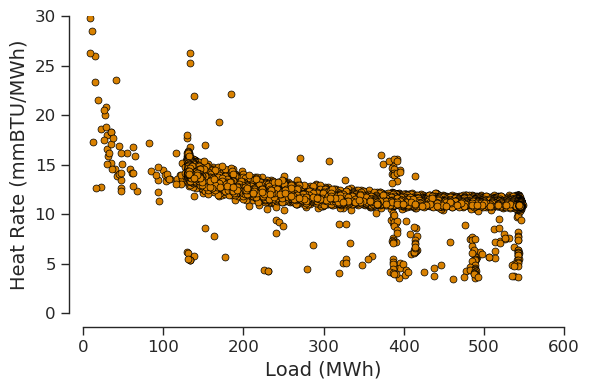

In [37]:
unit_id = '7097_**1'
raw_unit = boiler_raw[unit_id][['load', 'heat_rate']].values

f_path = os.path.join(fig_dir, 'figure_1.pdf')
mplt.line_plot(raw_unit, despine=True,
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('orange',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 600), ylim=(0, 30),
               filename=f_path,
          )

### Figure 2

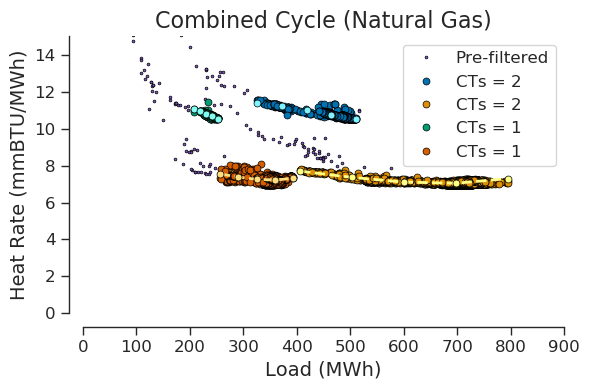

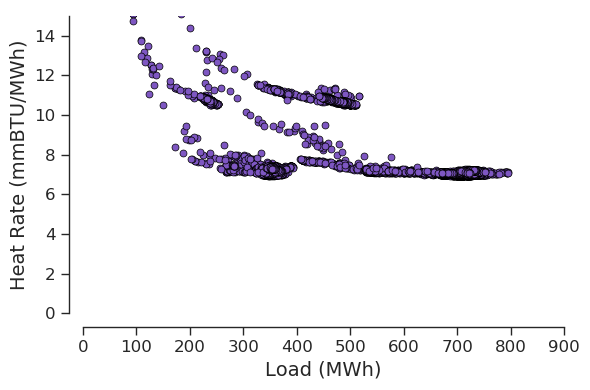

In [38]:
unit_id = '55411_CC1'
filtered_unit = cc_filtered[unit_id]
clean_unit = filtered_unit[['load', 'heat_rate']].values
pos = filtered_unit['cluster'] >= 0

title = 'Combined Cycle (Natural Gas)'
clusters = len(filtered_unit.loc[pos, 'cluster'].unique())
colors = sns.color_palette('colorblind', clusters)
cluster_units = [clean_unit,]
cluster_fits = []
legend = ['Pre-filtered',]
for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
    cts = int(cluster_df.iloc[0]['cts'])
    legend.append('CTs = {}'.format(cts))
    cluster_units.append(cluster_df[['load', 'heat_rate']].values)
    colors.append(lighten(colors[c], 0.5))
    cluster_id = '{}-{}'.format(unit_id, c)
    cluster_fits.append(get_hr_fit(cc_fits, cluster_id))

colors = mplt.get_COLORS(('purple', )) + colors
plt_data = cluster_units + cluster_fits
linestyles=('', ) * (len(legend) + 1) + ('--',) * len(legend)
marker_size = (2, ) + (5, ) * (len(plt_data) - 1)

f_path = os.path.join(fig_dir, 'toc_art.pdf')
mplt.line_plot(*plt_data, despine=True, title=title,
               linestyles=linestyles , markers=('o', ), markersize=marker_size,
               colors=colors,
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 900), ylim=(0, 15),
               legend=legend, legend_loc=1,
               filename=f_path,
          )


cluster_units = []
legend = []
for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
    cts = int(cluster_df.iloc[0]['cts'])
    legend.append('CTs = {}'.format(cts))
    cluster_units.append(cluster_df[['load', 'heat_rate']].values)
    
f_path = os.path.join(fig_dir, 'figure_2.pdf')
mplt.line_plot(clean_unit, despine=True,
               linestyles=('', ), markers=('o', ),
               colors=mplt.get_COLORS(('purple',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 900), ylim=(0, 15),
               filename=f_path,
          )

### Figure 3

In [39]:
fits_dir = os.path.join(data_dir, 'CEMS_Fits')
filtered_fits = npd.Fits(fits_dir)

fits_dir = os.path.join(data_dir, 'Final_Fits')
final_fits = npd.Fits(fits_dir)

filtered_boiler = filtered_fits['CT (NG)']
pos = filtered_boiler['a0'].isnull()
filtered_boiler = filtered_boiler.loc[~pos]

final_boiler = final_fits['CT (NG)']
pos = final_boiler['a0'].isnull()
final_boiler = final_boiler.loc[~pos]

pos = filtered_boiler['unit_id'].isin(final_boiler['unit_id'])
dropped_units = filtered_boiler.loc[~pos].sort_values('heat_rate(load_max)')

dropped_units.iloc[[0, -1]]

,unit_id,a4,a3,a2,a1,a0,load_min,load_2,load_3,load_4,...,heat_rate(load_4),heat_rate(load_max),latitude,longitude,state,EPA_region,NERC_region,unit_type,fuel_type,group_type
1278,7063_**1,-1.410892e-08,9.186010e-07,0.000212,-0.030311,6.030995,29.853001,44.05725,58.261499,72.465749,...,4.906504,4.795855,31.2546,-88.029900,AL,4.0,NaN,Other turbine,Pipeline Natural Gas,CT (NG)
96,2092_3,5.440641e-04,-4.286347e-02,1.266302,-17.206022,114.184133,8.667000,13.48200,18.297000,23.112000,...,18.995220,18.622291,38.7865,-94.276802,MO,7.0,NaN,Combustion turbine,Pipeline Natural Gas,CT (NG)


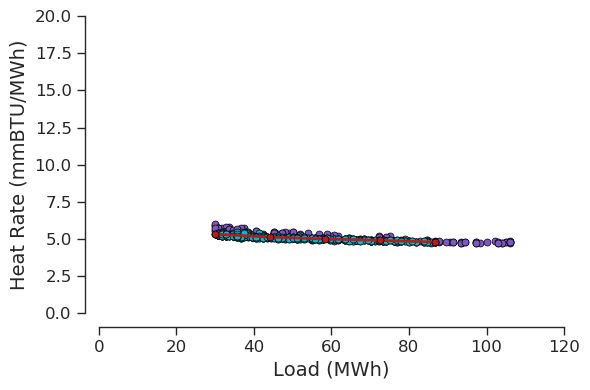

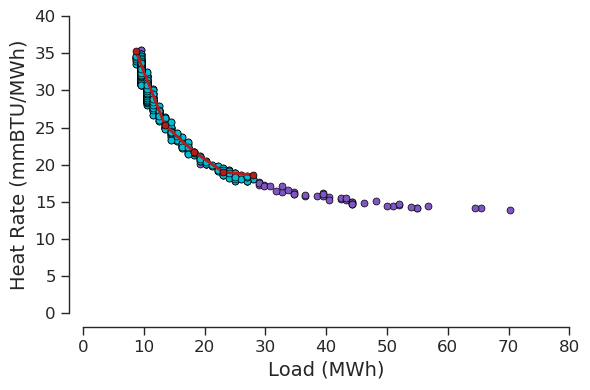

In [40]:
threshold_lines = [[[0, 7.9], [200, 7.9]], [[0, 13.7], [200, 13.7]]]

efficient_unit = '7063_**1'

fits_dir = os.path.join(data_dir, 'CEMS_Fits')
fits = npd.Fits(fits_dir)
fits = fits['CT (NG)']

filtered_unit = ct_filtered[efficient_unit]
clean_unit = filtered_unit[['load', 'heat_rate']].values
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(fits, efficient_unit)
f_path = os.path.join(fig_dir, 'figure_3a.pdf')
mplt.line_plot(clean_unit, final_unit, unit_fit, despine=True,
               linestyles=('', '', '-', ), markers=('o',),
               colors=mplt.get_COLORS(('purple', 'cyan', 'red',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 120), ylim=(0, 20),
               filename=f_path,
          )


inefficient_unit = '2092_3'

filtered_unit = ct_filtered[inefficient_unit]
clean_unit = filtered_unit[['load', 'heat_rate']].values
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(fits, inefficient_unit)
f_path = os.path.join(fig_dir, 'figure_3b.pdf')
mplt.line_plot(clean_unit, final_unit, unit_fit, despine=True,
               linestyles=('', '', '-', ), markers=('o',),
               colors=mplt.get_COLORS(('purple', 'cyan', 'red',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 80), ylim=(0, 40),
               filename=f_path,
          )


### Figure 4

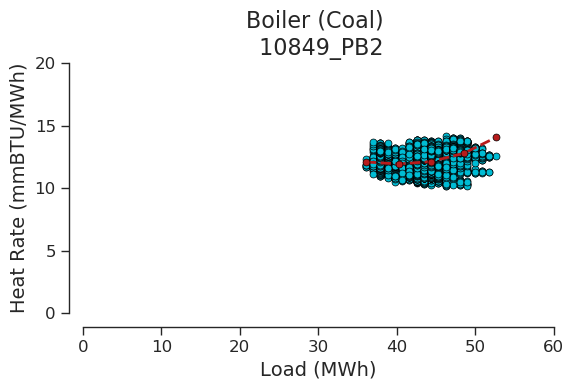

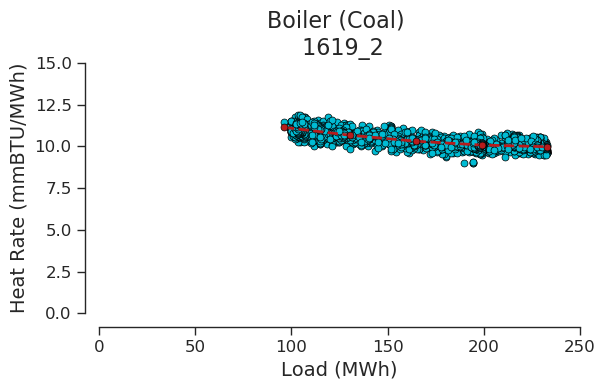

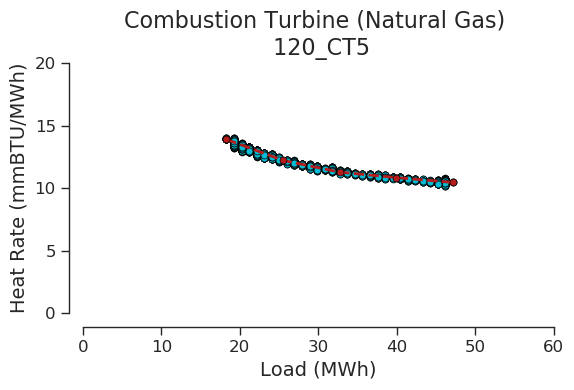

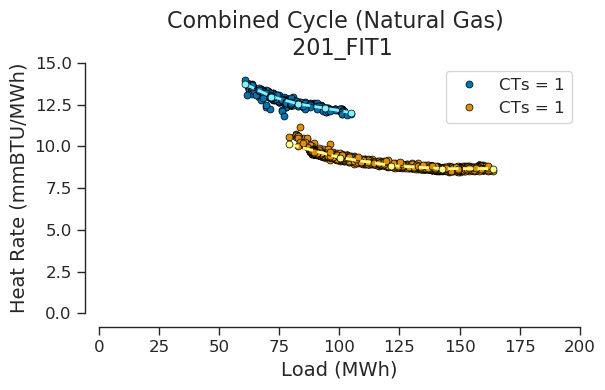

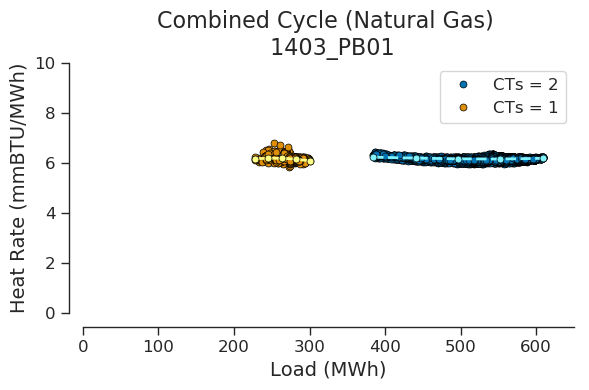

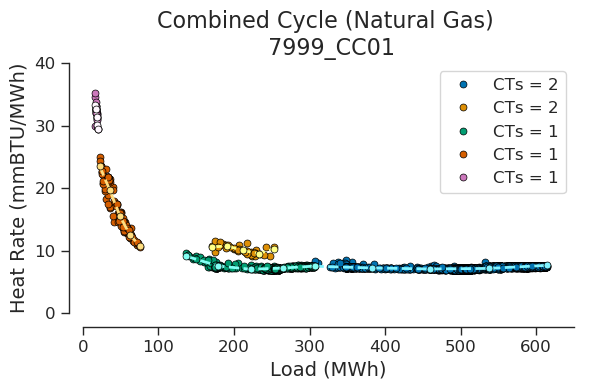

In [41]:
unit_id = '10849_PB2'
title = 'Boiler (Coal) \n {}'.format(unit_id)
filtered_unit = boiler_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(boiler_fits, unit_id)
f_path = os.path.join(fig_dir, 'figure_4a.pdf')
mplt.line_plot(final_unit, unit_fit, despine=True,
               title=title,
               linestyles=('', '--'), markers=('o',),
               colors=mplt.get_COLORS(('cyan', 'red')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 60), ylim=(0, 20),
               filename=f_path,
          )


unit_id = '1619_2'
title = 'Boiler (Coal) \n {}'.format(unit_id)
filtered_unit = boiler_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(boiler_fits, unit_id)
f_path = os.path.join(fig_dir, 'figure_4b.pdf')
mplt.line_plot(final_unit, unit_fit, despine=True,
               title=title,
               linestyles=('', '--'), markers=('o',),
               colors=mplt.get_COLORS(('cyan', 'red')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 250), ylim=(0, 15),
               filename=f_path,
          )


unit_id = '120_CT5'
title = 'Combustion Turbine (Natural Gas) \n {}'.format(unit_id)
filtered_unit = ct_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(ct_fits, unit_id)
f_path = os.path.join(fig_dir, 'figure_4c.pdf')
mplt.line_plot(final_unit, unit_fit, despine=True,
               title=title,
               linestyles=('', '--'), markers=('o',),
               colors=mplt.get_COLORS(('cyan', 'red')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 60), ylim=(0, 20),
               filename=f_path,
          )


unit_id = '201_FIT1'
title = 'Combined Cycle (Natural Gas) \n {}'.format(unit_id)
filtered_unit = cc_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
clusters = len(filtered_unit.loc[pos, 'cluster'].unique())
colors = sns.color_palette('colorblind', clusters)
cluster_units = []
cluster_fits = []
legend = []
for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
    cts = int(cluster_df.iloc[0]['cts'])
    legend.append('CTs = {}'.format(cts))
    cluster_units.append(cluster_df[['load', 'heat_rate']].values)
    colors.append(lighten(colors[c], 0.5))
    cluster_id = '{}-{}'.format(unit_id, c)
    cluster_fits.append(get_hr_fit(cc_fits, cluster_id))

plt_data = cluster_units + cluster_fits
linestyles=('', ) * len(legend) + ('--',) * len(legend)
f_path = os.path.join(fig_dir, 'figure_4d.pdf')
mplt.line_plot(*plt_data, despine=True, title=title,
               linestyles=linestyles , markers=('o', ),
               colors=colors,
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 200), ylim=(0, 15),
               legend=legend, legend_loc=0,
               filename=f_path,
          )


unit_id = '1403_PB01'
title = 'Combined Cycle (Natural Gas) \n {}'.format(unit_id)
filtered_unit = cc_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
clusters = len(filtered_unit.loc[pos, 'cluster'].unique())
colors = sns.color_palette('colorblind', clusters)
cluster_units = []
cluster_fits = []
legend = []
for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
    cts = int(cluster_df.iloc[0]['cts'])
    legend.append('CTs = {}'.format(cts))
    cluster_units.append(cluster_df[['load', 'heat_rate']].values)
    colors.append(lighten(colors[c], 0.5))
    cluster_id = '{}-{}'.format(unit_id, c)
    cluster_fits.append(get_hr_fit(cc_fits, cluster_id))

plt_data = cluster_units + cluster_fits
linestyles=('', ) * len(legend) + ('--',) * len(legend)
f_path = os.path.join(fig_dir, 'figure_4e.pdf')
mplt.line_plot(*plt_data, despine=True, title=title,
               linestyles=linestyles , markers=('o', ),
               colors=colors,
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 650), ylim=(0, 10),
               legend=legend, legend_loc=0,
               filename=f_path,
          )


unit_id = '7999_CC01'
title = 'Combined Cycle (Natural Gas) \n {}'.format(unit_id)
filtered_unit = cc_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
clusters = len(filtered_unit.loc[pos, 'cluster'].unique())
colors = sns.color_palette('colorblind', clusters)
cluster_units = []
cluster_fits = []
legend = []
for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
    cts = int(cluster_df.iloc[0]['cts'])
    legend.append('CTs = {}'.format(cts))
    cluster_units.append(cluster_df[['load', 'heat_rate']].values)
    colors.append(lighten(colors[c], 0.5))
    cluster_id = '{}-{}'.format(unit_id, c)
    cluster_fits.append(get_hr_fit(cc_fits, cluster_id))

plt_data = cluster_units + cluster_fits
linestyles=('', ) * len(legend) + ('--',) * len(legend)
f_path = os.path.join(fig_dir, 'figure_4f.pdf')
mplt.line_plot(*plt_data, despine=True, title=title,
               linestyles=linestyles , markers=('o', ),
               colors=colors,
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 650), ylim=(0, 40),
               legend=legend, legend_loc=0,
               filename=f_path,
          )

### Figure 5

In [12]:
def stacked_bar_plot(*bar_arrays, **kwargs):
    """
    Parameters
    ----------
    arrays : list | tuple
        Either a tuple or list of nx1 arrays
    colors : list | tuple | str
        List of colors or color palette to use.
    """
    def plot_func(axis, *bar_arrays, colors=colors,
                  bar_width=1, bar_spacing=3, capsize=7,
                  **kwargs):
        if not isinstance(colors, list):
            colors = [colors,]

        color_options = []
        for c in colors:
            c = mplt.lines.get_colors(c)
            color_options.append(c)
    
        color_options = itertools.cycle(color_options)
        ri = None
        for bars in bar_arrays:
            bar_colors = itertools.cycle(next(color_options))
            if ri is None:
                ri = np.arange(len(bars)) * bar_spacing
            else:
                ri = [x + bar_width for x in ri]
            
            bars = bars.T
            bottoms = np.roll(np.cumsum(bars, axis=0), 1, axis=0)
            bottoms[0, :] = 0
            for b, bt in zip(bars, bottoms):
                axis.bar(ri, b, bottom=bt, width=bar_width,
                         color=next(bar_colors), edgecolor='black',
                         )

    mplt.base.plotting_base(plot_func, *bar_arrays,  **kwargs)

No handles with labels found to put in legend.


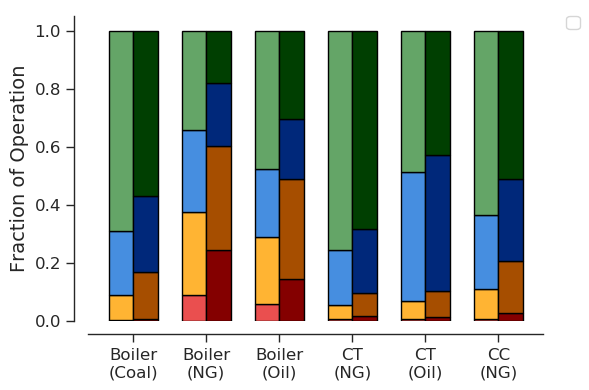

In [42]:
path = os.path.join(out_dir, 'final_fits', 'final_quartile_stats.csv')
types = ['Boiler (Coal)', 'Boiler (NG)', 'Boiler (Oil)', 'CT (NG)', 'CT (Oil)',
         'CC (NG)']
q_stats = pd.read_csv(path, index_col=0).loc[types]
gen_stats = q_stats.iloc[:, [0, 2, 4, 6]].values
time_stats = q_stats.iloc[:, [1, 3, 5, 7]].values

colors = mplt.get_COLORS(('red', 'orange', 'blue', 'green'))
gen_colors = [lighten(c, 0.2) for c in colors]
time_colors = [darken(c, 0.2) for c in colors]

x_ticks = (np.arange(len(types)) * 3) + 0.5
tick_labels = []
for t in types:
    t = t.replace(' (', '\n(')
    t = t.replace('CT', 'Combustion Turbine')
    t = t.replace('CC', 'Combined Cycle')
    t = t.replace('NG', 'Natural Gas')
    tick_labels.append(t)

tick_labels = [i.replace(' (', '\n(')
               for i in q_stats.index]
f_path = os.path.join(fig_dir, 'figure_5a.pdf')
stacked_bar_plot(gen_stats, time_stats, despine=True,
                 colors=[gen_colors, time_colors],
                 xticks=x_ticks, xtick_labels=tick_labels,
                 xtick_rotation=0, ylabel='Fraction of Operation',
                 filename=f_path
                )

In [43]:
path = os.path.join(out_dir, 'final_fits', 'Boiler (Coal)_final_quartile_stats.csv')

q_stats = pd.read_csv(path, index_col=0)
q_stats

,Q1_gen_frac,Q1_time_frac,Q2_gen_frac,Q2_time_frac,Q3_gen_frac,Q3_time_frac,Q4_gen_frac,Q4_time_frac
bin_0,0.000634,0.003728,0.085036,0.158894,0.208898,0.250715,0.705431,0.586663
bin_1,0.005139,0.018395,0.101609,0.180055,0.268617,0.301885,0.624635,0.499664
bin_2,0.097845,0.176211,0.473590,0.572687,0.215782,0.140969,0.212783,0.110132


No handles with labels found to put in legend.


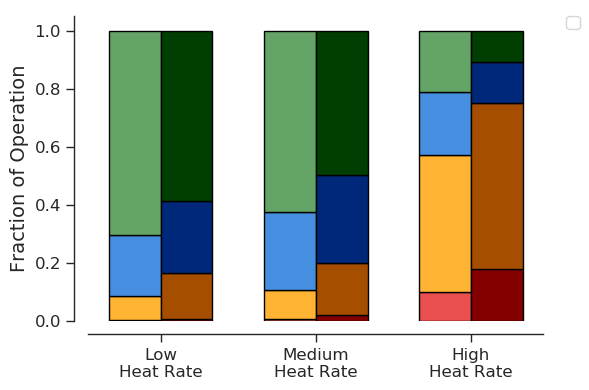

No handles with labels found to put in legend.


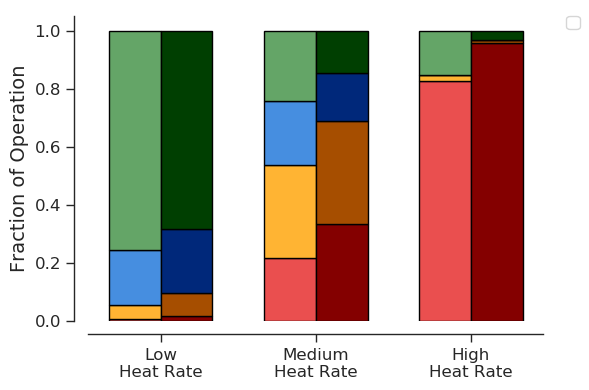

In [44]:
path = os.path.join(out_dir, 'final_fits', 'Boiler (Coal)_final_quartile_stats.csv')
q_stats = pd.read_csv(path, index_col=0)
x_ticks = (np.arange(len(q_stats)) * 3) + 0.5
tick_labels = ['Low\nHeat Rate', 'Medium\nHeat Rate', 'High\nHeat Rate']
gen_stats = q_stats.iloc[:, [0, 2, 4, 6]].values
time_stats = q_stats.iloc[:, [1, 3, 5, 7]].values

colors = mplt.get_COLORS(('red', 'orange', 'blue', 'green'))
gen_colors = [lighten(c, 0.2) for c in colors]
time_colors = [darken(c, 0.2) for c in colors]

f_path = os.path.join(fig_dir, 'figure_5b.pdf')
stacked_bar_plot(gen_stats, time_stats, despine=True,
                 colors=[gen_colors, time_colors],
                 xticks=x_ticks, xtick_labels=tick_labels,
                 xtick_rotation=0, ylabel='Fraction of Operation',
                 filename=f_path
                )

path = os.path.join(out_dir, 'final_fits', 'CT (NG)_final_quartile_stats.csv')
q_stats = pd.read_csv(path, index_col=0)
x_ticks = (np.arange(len(q_stats)) * 3) + 0.5
tick_labels = ['Low\nHeat Rate', 'Medium\nHeat Rate', 'High\nHeat Rate']
gen_stats = q_stats.iloc[:, [0, 2, 4, 6]].values
time_stats = q_stats.iloc[:, [1, 3, 5, 7]].values

colors = mplt.get_COLORS(('red', 'orange', 'blue', 'green'))
gen_colors = [lighten(c, 0.2) for c in colors]
time_colors = [darken(c, 0.2) for c in colors]

f_path = os.path.join(fig_dir, 'figure_5c.pdf')
stacked_bar_plot(gen_stats, time_stats, despine=True,
                 colors=[gen_colors, time_colors],
                 xticks=x_ticks, xtick_labels=tick_labels,
                 xtick_rotation=0, ylabel='Fraction of Operation',
                 filename=f_path
                )

## Figure 6

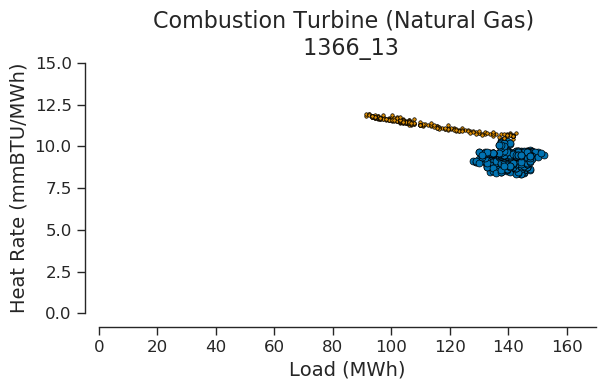

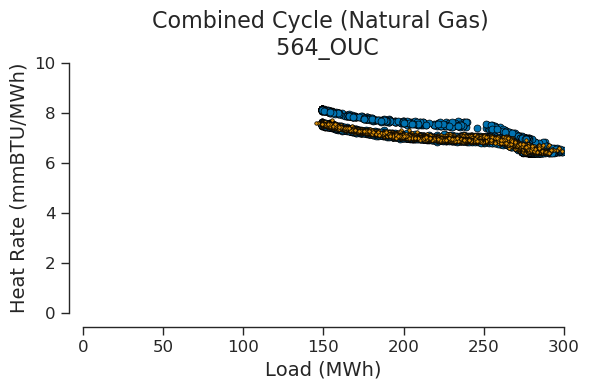

In [6]:
unit_id = '1366_13'
filtered_unit = ct_filtered[unit_id]
filtered_unit.index = pd.to_datetime(filtered_unit['time'])
t = '2017-06-18'
split = pd.to_datetime(t)

pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos]
pos = final_unit.index > split
t1 = final_unit.loc[~pos, ['load', 'heat_rate']].values
t2 = final_unit.loc[pos, ['load', 'heat_rate']].values

f_path = os.path.join(fig_dir, 'figure_6a.pdf')
title = 'Combustion Turbine (Natural Gas) \n {}'.format(unit_id)
mplt.line_plot(t1, t2, despine=True,
               title=title,
               linestyles=('',), markers=('o', '.'),
               colors='colorblind',
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 170), ylim=(0, 15),
               filename=f_path
              )

unit_id = '564_OUC'
f_path=None
filtered_unit = cc_filtered[unit_id]
filtered_unit.index = pd.to_datetime(filtered_unit['time'])
t = '2016-08-01'
split = pd.to_datetime(t)

pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos]
pos = final_unit.index > split
t1 = final_unit.loc[~pos, ['load', 'heat_rate']].values
t2 = final_unit.loc[pos, ['load', 'heat_rate']].values

f_path = os.path.join(fig_dir, 'figure_6b.pdf')
title = 'Combined Cycle (Natural Gas) \n {}'.format(unit_id)
mplt.line_plot(t1, t2, despine=True,
               title=title,
               linestyles=('',), markers=('o', '.'),
               colors='colorblind',
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 300), ylim=(0, 10),
               filename=f_path,
              )


## SI
### S2

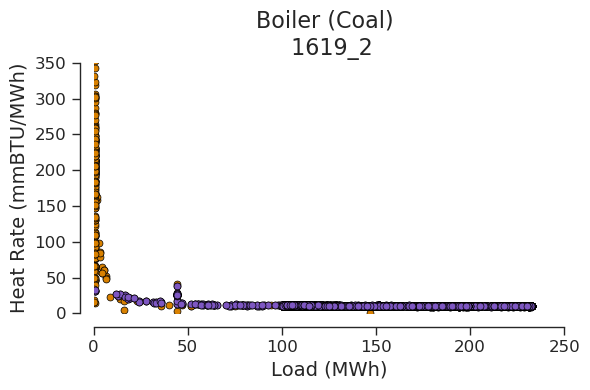

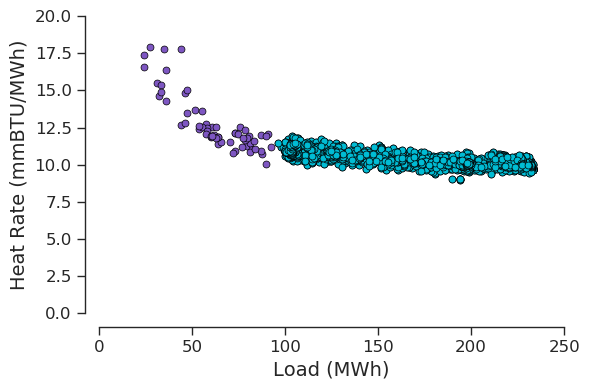

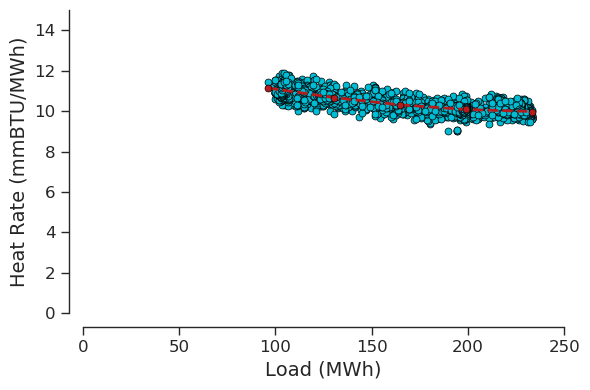

In [6]:
unit_id = '1619_2'
title = 'Boiler (Coal) \n {}'.format(unit_id)
raw_unit = boiler_raw[unit_id][['load', 'heat_rate']].values
filtered_unit = boiler_filtered[unit_id]
clean_unit = filtered_unit.loc[:, ['load', 'heat_rate']].values
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(boiler_fits, unit_id)

f_path = os.path.join(fig_dir, 'figure_S2a.pdf')
mplt.line_plot(raw_unit, clean_unit, despine=True,
               title=title,
               linestyles=('', ), markers=('o',),
               colors=mplt.get_COLORS(('orange', 'purple')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 250), ylim=(0, 350),
               filename=f_path,
          )

f_path = os.path.join(fig_dir, 'figure_S2c.pdf')
mplt.line_plot(clean_unit, final_unit, despine=True,
               linestyles=('', ), markers=('o',),
               colors=mplt.get_COLORS(('purple', 'cyan')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 250), ylim=(0, 20),
               filename=f_path,
          )

f_path = os.path.join(fig_dir, 'figure_S2e.pdf')
mplt.line_plot(final_unit, unit_fit, despine=True,
               linestyles=('', '--'), markers=('o',),
               colors=mplt.get_COLORS(('cyan', 'red')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 250), ylim=(0, 15),
               filename=f_path,
          )

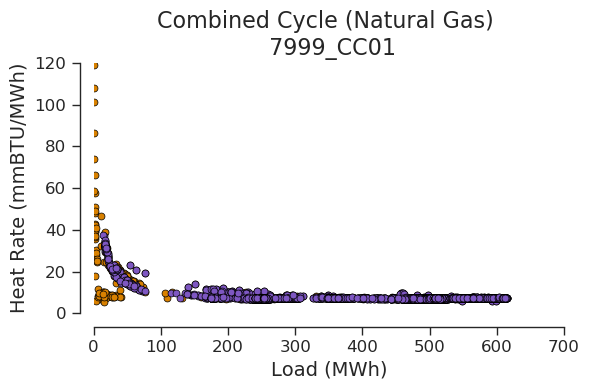

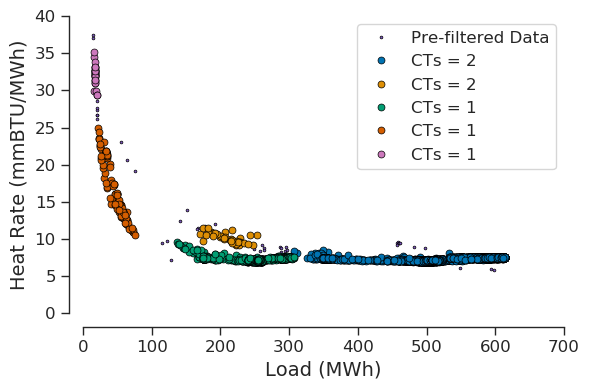

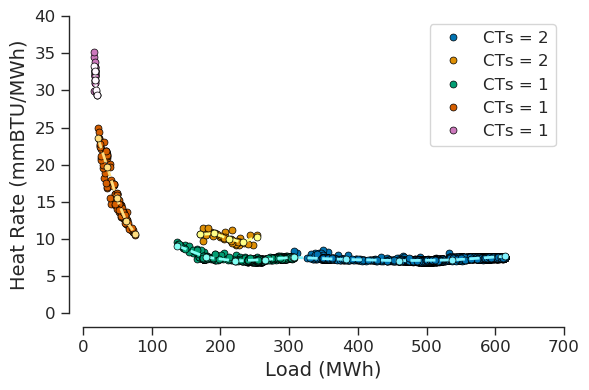

In [47]:
unit_id = '7999_CC01'
title = 'Combined Cycle (Natural Gas) \n {}'.format(unit_id)
raw_unit = get_raw_cc(cc_raw, unit_id)
filtered_unit = cc_filtered[unit_id]
pos = filtered_unit['cluster'] >= 0
clean_unit = filtered_unit.loc[:, ['load', 'heat_rate']].values

f_path = os.path.join(fig_dir, 'figure_S2b.pdf')
mplt.line_plot(raw_unit, clean_unit, despine=True,
               title=title,
               linestyles=linestyles , markers=('o', ),
               colors=mplt.get_COLORS(('orange', 'purple')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 700), ylim=(0, 120),
               filename=f_path,
          )

clusters = len(filtered_unit.loc[pos, 'cluster'].unique())
colors = sns.color_palette('colorblind', clusters)
cluster_units = []
cluster_fits = []
legend = ['Pre-filtered Data',]
for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
    cts = int(cluster_df.iloc[0]['cts'])
    legend.append('CTs = {}'.format(cts))
    cluster_units.append(cluster_df[['load', 'heat_rate']].values)
    colors.append(lighten(colors[c], 0.5))
    cluster_id = '{}-{}'.format(unit_id, c)
    cluster_fits.append(get_hr_fit(cc_fits, cluster_id))

plt_colors = mplt.get_COLORS(('purple', )) + colors
plt_data = [clean_unit,] + cluster_units
marker_size = (2, ) + (5, ) * (len(plt_data) - 1)
f_path = os.path.join(fig_dir, 'figure_s2d.pdf')
mplt.line_plot(*plt_data, despine=True,
               linestyles=('',) , markers=('o', ), markersize=marker_size,
               colors=plt_colors,
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 700), ylim=(0, 40),
               legend=legend, legend_loc=0,
               filename=f_path,
          )

plt_data = cluster_units + cluster_fits
linestyles=('', ) * len(cluster_units) + ('--',) * len(cluster_fits)
f_path = os.path.join(fig_dir, 'figure_s2f.pdf')
mplt.line_plot(*plt_data, despine=True,
               linestyles=linestyles, markers=('o', ),
               colors=colors,
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 700), ylim=(0, 40),
               legend=legend[1:], legend_loc=0,
               filename=f_path,
          )

### S3

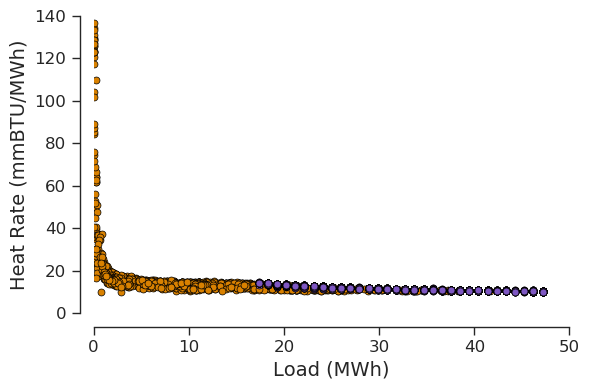

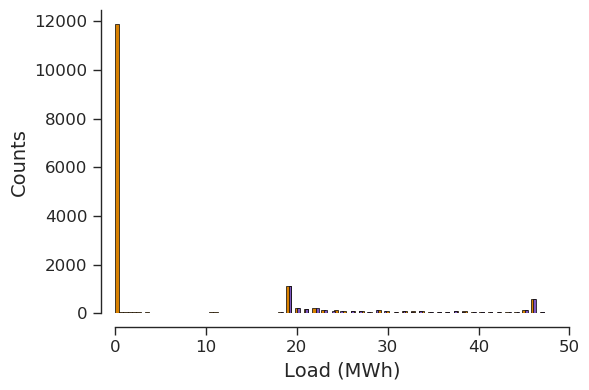

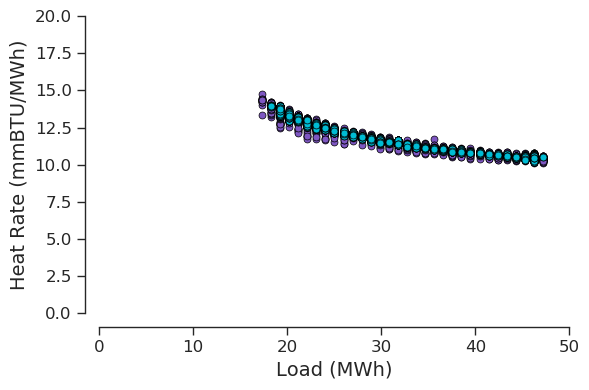

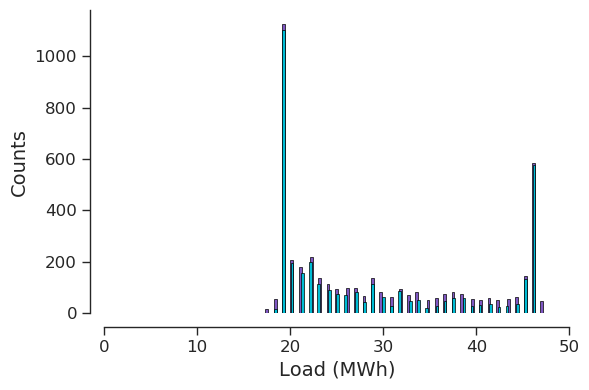

In [7]:
unit_id = '120_CT5'
raw_unit = ct_raw[unit_id][['load', 'heat_rate']].values
filtered_unit = ct_filtered[unit_id]
clean_unit = filtered_unit.loc[:, ['load', 'heat_rate']].values
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(ct_fits, unit_id)

f_path = os.path.join(fig_dir, 'figure_S3a.pdf')
mplt.line_plot(raw_unit, clean_unit, despine=True,
               linestyles=('', ), markers=('o',),
               colors=mplt.get_COLORS(('orange', 'purple')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 50), ylim=(0, 140),
               filename=f_path,
          )

f_path = os.path.join(fig_dir, 'figure_S3c.pdf')
mplt.hist_plot(raw_unit[:, 0], clean_unit[:, 0], despine=True,
               bins=100, kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'black',
                                                'linewidth': 0.5,
                                                "rwidth":None},
               colors=mplt.get_COLORS(('orange', 'purple')),
               xlabel='Load (MWh)', ylabel='Counts',
               xlim=(0, 50),
               filename=f_path,
          )

f_path = os.path.join(fig_dir, 'figure_S3b.pdf')
mplt.line_plot(clean_unit, final_unit, despine=True,
               linestyles=('', ), markers=('o',),
               colors=mplt.get_COLORS(('purple', 'cyan')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, 50), ylim=(0, 20),
               filename=f_path,
          )

f_path = os.path.join(fig_dir, 'figure_S3d.pdf')
mplt.hist_plot(clean_unit[:, 0], final_unit[:, 0], despine=True,
               bins=100, kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'black',
                                                'linewidth': 0.5,
                                                "rwidth":None},
               colors=mplt.get_COLORS(('purple', 'cyan')),
               xlabel='Load (MWh)', ylabel='Counts',
               xlim=(0, 50),
               filename=f_path,
          )

### S4

In [49]:
fit_dir = os.path.join(data_dir, "CEMS_Fits")
hr_fits = npd.Fits(fit_dir)

Boiler (Coal) =  [ 8.4645264 12.7324111]


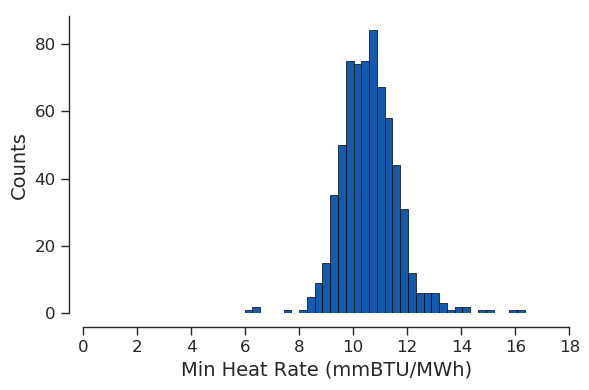

CT (NG) =  [ 7.92163639 13.73326682]


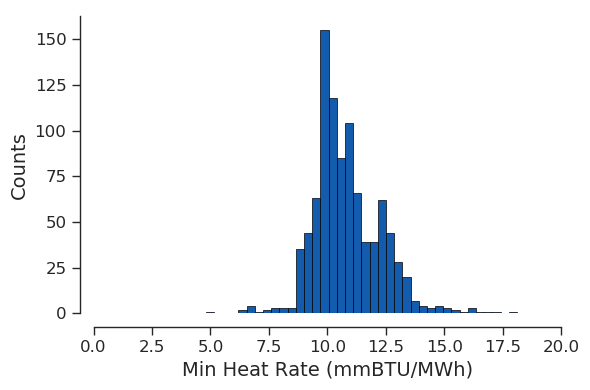

	- Minimun heat rate value is < 4.5!
	- Minimun heat rate value is < 4.5!


CC (NG) =  [5.69633404 8.89956755]


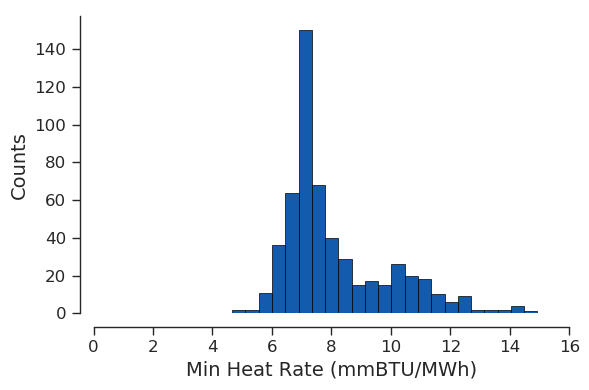

In [50]:
group_fits = hr_fits['Boiler (Coal)']
stdev_multiplier=2

min_hr = group_fits.apply(npd.filter.FitFilter._get_hr_min, axis=1).dropna()
mean = min_hr.mean()
stdev = min_hr.std()
thresh = np.array([-stdev_multiplier, stdev_multiplier]) * stdev + mean
print('Boiler (Coal) = ', thresh)
f_path = os.path.join(fig_dir, 'figure_s4a.pdf')
mplt.hist_plot(min_hr.values, despine=True,
               bins='auto', kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'black',
                                                'linewidth': 0.5,
                                                "rwidth":None},
               colors=mplt.get_COLORS(('blue',)),
               xlabel='Min Heat Rate (mmBTU/MWh)', ylabel='Counts',
               xlim=(0, 18),
               filename=f_path,
          )


group_fits = hr_fits['CT (NG)']
stdev_multiplier=2

min_hr = group_fits.apply(npd.filter.FitFilter._get_hr_min, axis=1).dropna()
mean = min_hr.mean()
stdev = min_hr.std()
thresh = np.array([-stdev_multiplier, stdev_multiplier]) * stdev + mean
print('CT (NG) = ', thresh)
f_path = os.path.join(fig_dir, 'figure_s4b.pdf')
mplt.hist_plot(min_hr.values, despine=True,
               bins='auto', kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'black',
                                                'linewidth': 0.5,
                                                "rwidth":None},
               colors=mplt.get_COLORS(('blue',)),
               xlabel='Min Heat Rate (mmBTU/MWh)', ylabel='Counts',
               xlim=(0, 20),
               filename=f_path,
          )


cc_fits = hr_fits['CC (NG)']
cc_fits['cc_id'] = cc_fits['unit_id'].str.split('-').str[0]
cc_fits = cc_fits.set_index('cc_id')
cc_min_hr = cc_fits.apply(npd.filter.FitFilter._get_hr_min, axis=1).dropna().to_frame().reset_index()
min_hr = cc_min_hr.groupby('cc_id').min()

m_hr = min_hr.values
m_hr = m_hr[m_hr < 9.5]
mean = m_hr.mean()
stdev = m_hr.std()
thresh = np.array([-2, 2]) * stdev + mean
print('CC (NG) = ', thresh)
f_path = os.path.join(fig_dir, 'figure_s4c.pdf')
mplt.hist_plot(min_hr.values, despine=True,
               bins='auto', kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'black',
                                                'linewidth': 0.5,
                                                "rwidth":None},
               colors=mplt.get_COLORS(('blue',)),
               xlabel='Min Heat Rate (mmBTU/MWh)', ylabel='Counts',
               xlim=(0, 16),
               filename=f_path,
          )

### S6

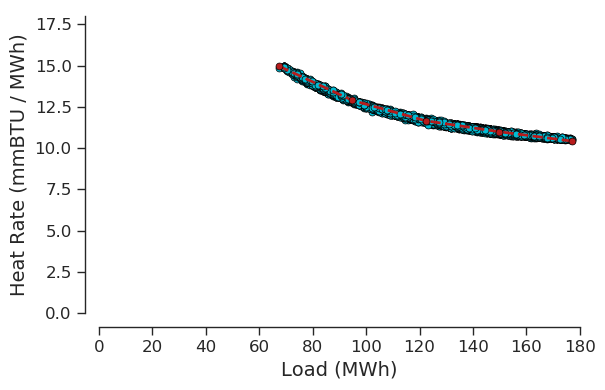

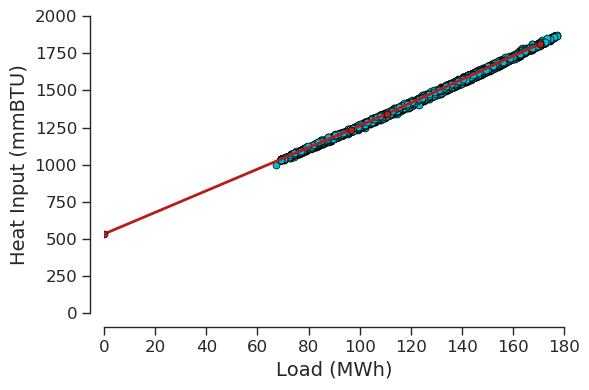

In [51]:
# CT Unit
unit_id = '7834_CT2A'
filtered_unit = ct_filtered[unit_id]
clean_unit = filtered_unit.loc[:, ['load', 'heat_rate']].values
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
unit_fit = get_hr_fit(ct_fits, unit_id)
f_path = os.path.join(fig_dir, 'figure_s6a.pdf')
mplt.line_plot(final_unit, unit_fit,
               linestyles=['', '--'], markers=['o', 'o'],
               colors=mplt.get_COLORS(['cyan', 'red']),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU / MWh)',
               xlim=(0, 180), ylim=(0, 18),
               filename=f_path,
              )


unit_data = filtered_unit.loc[pos, ['load', 'HTINPUT']].values
heat_base = 534.0711200044251
hr_incs = [7.265977388931994, 7.561594062427158, 7.853129259716792]
load_pnts = [96.64700737829611, 110.56053320459712, 170.451]

x = [0]
y = [heat_base]
for m, x_i in zip(hr_incs, load_pnts):
    y_i = m * (x_i - x[-1]) + (y[-1])
    x.append(x_i)
    y.append(y_i)
    
unit_fit = np.dstack((x, y))[0]
f_path = os.path.join(fig_dir, 'figure_s6b.pdf')
mplt.line_plot(unit_data, unit_fit,
               linestyles=('', '-'), markers=('o', 'o',),
               colors=mplt.get_COLORS(('cyan', 'red',)),
               #title=file_name,
               xlabel='Load (MWh)', ylabel='Heat Input (mmBTU)',
               xlim=(0, 180), ylim=(0, 2000),
               filename=f_path,
               )